In [1]:
%matplotlib widget
# %load_ext autoreload
# %autoreload 2
from fig12code import *

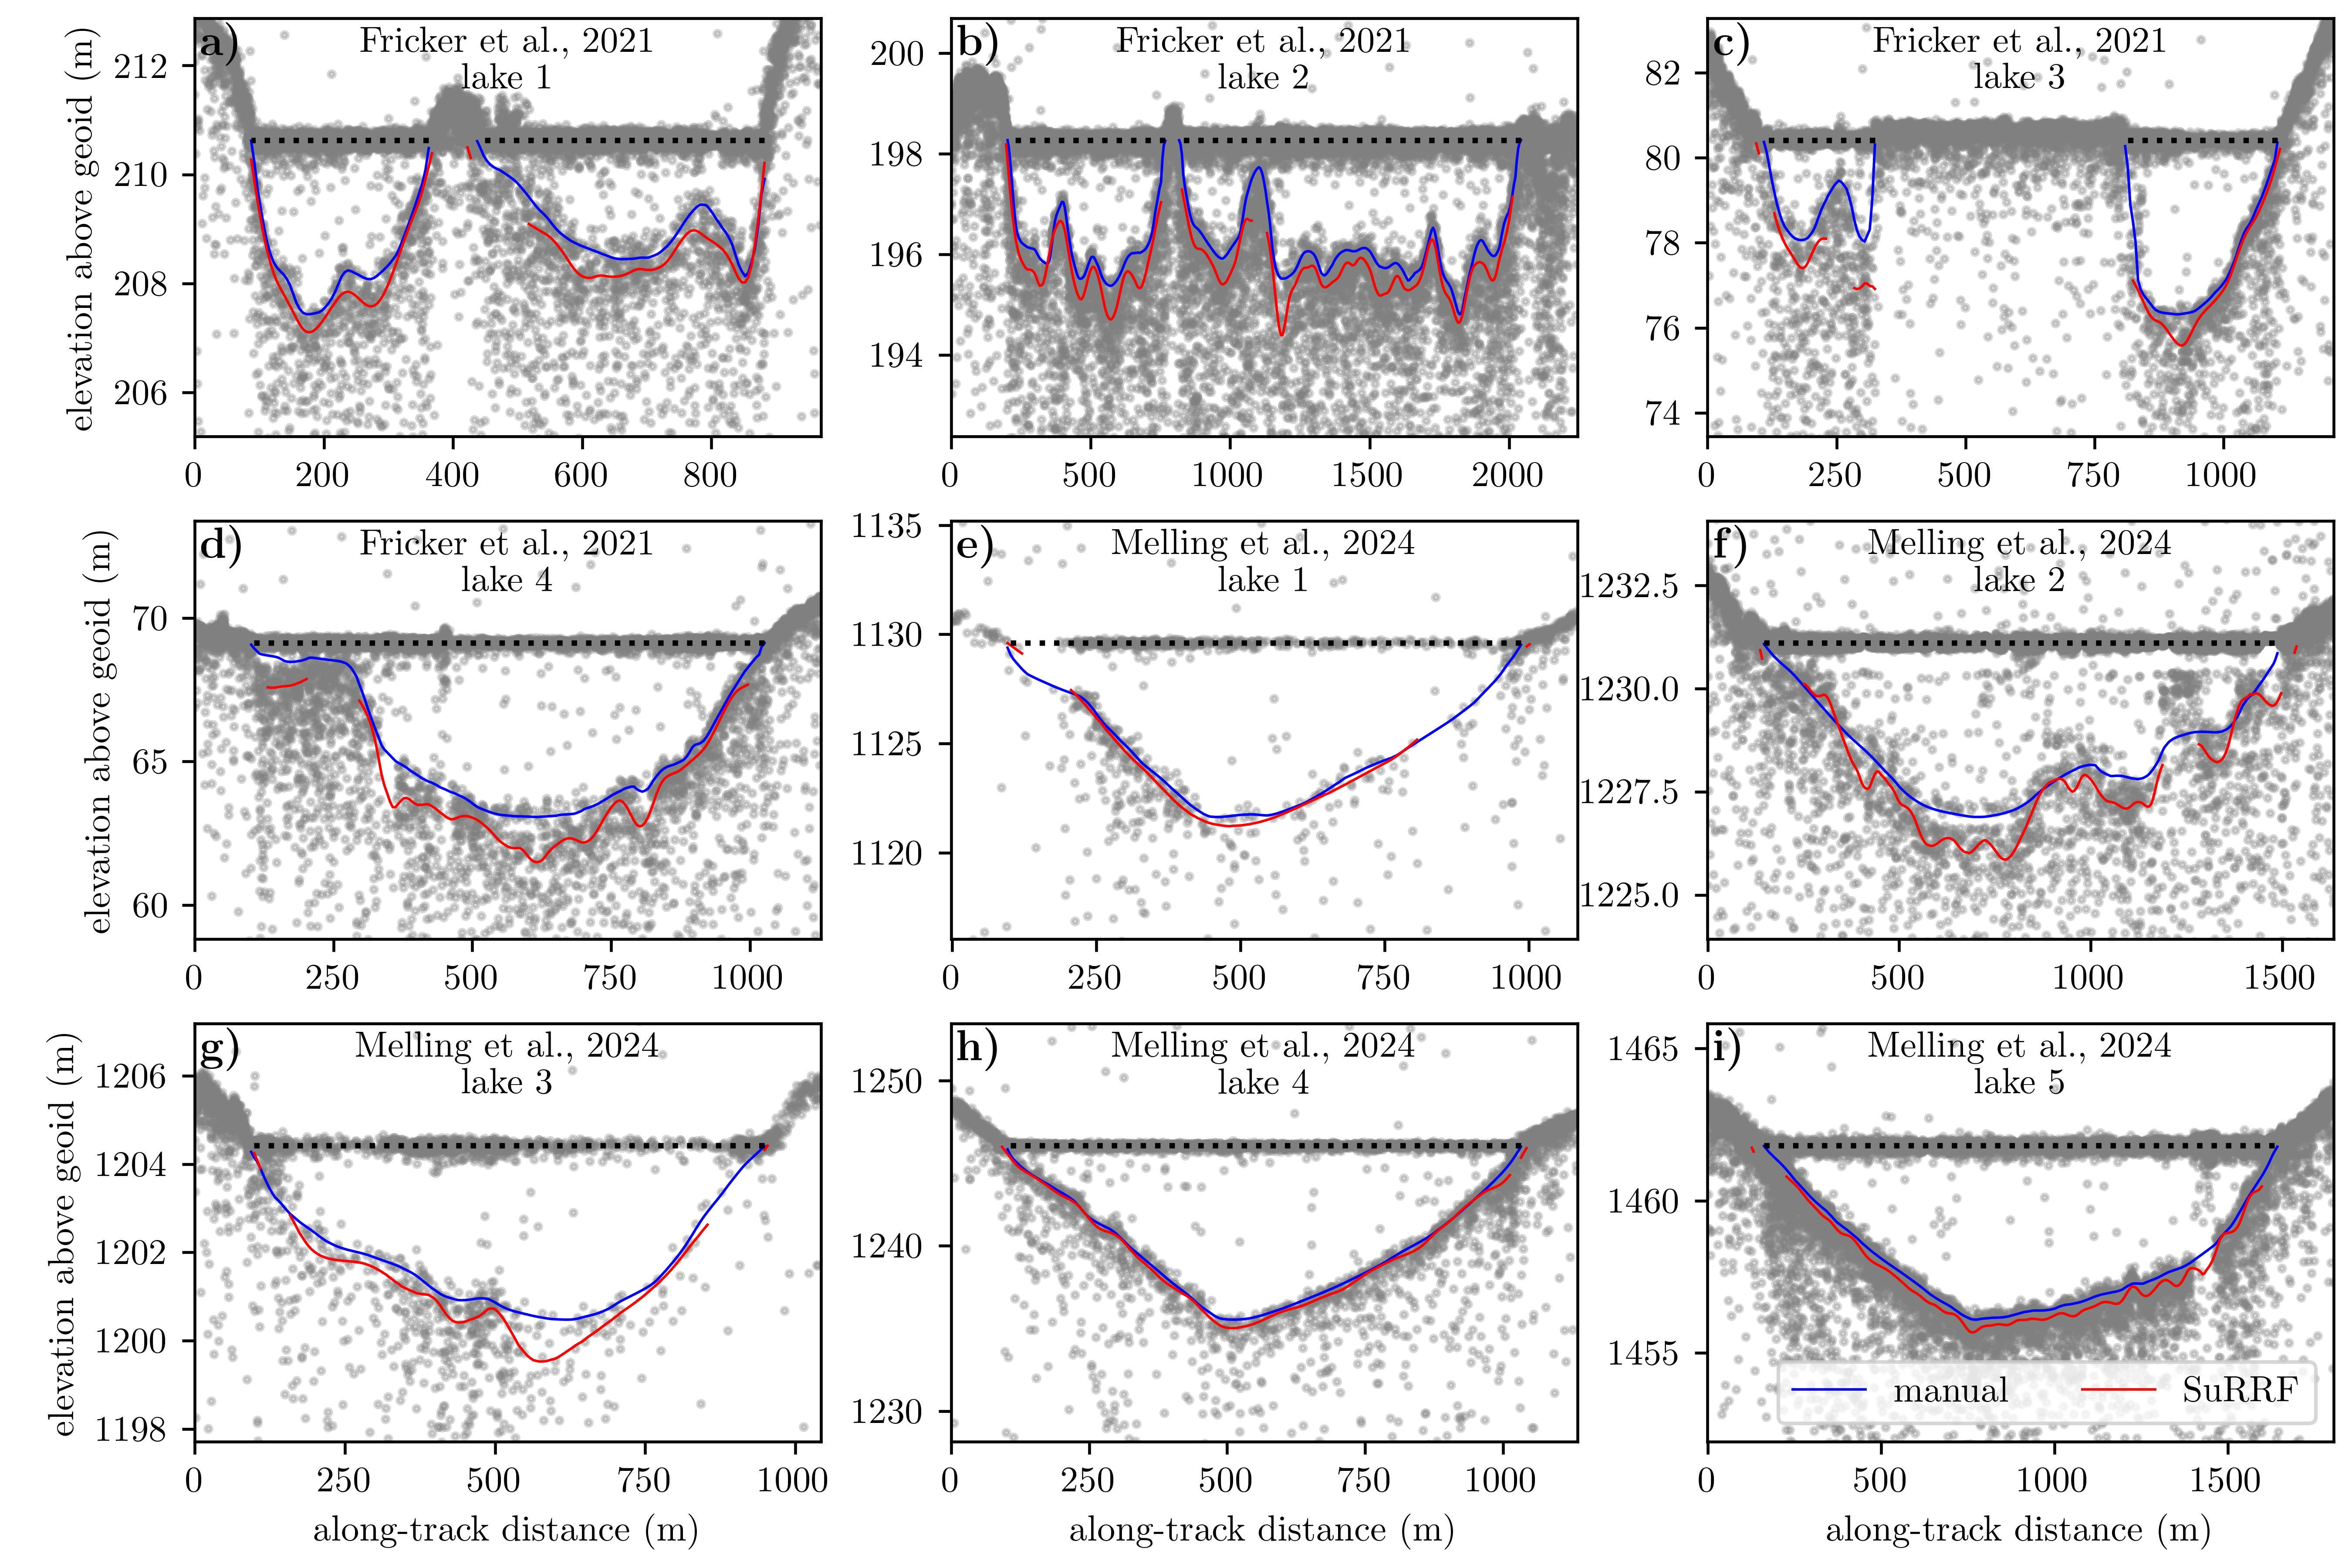

In [2]:
# input data
dfm = pd.read_csv('data/manual_estimates.csv',index_col=False)
lakefns = {
    1: 'data/lake_amery_fricker_1.h5',
    2: 'data/lake_amery_fricker_2.h5',
    3: 'data/lake_amery_fricker_3.h5',
    4: 'data/lake_amery_fricker_4.h5',
    5: 'data/lake_greenland_melling_1.h5',
    6: 'data/lake_greenland_melling_2.h5',
    7: 'data/lake_greenland_melling_3.h5',
    8: 'data/lake_greenland_melling_4.h5',
    9: 'data/lake_greenland_melling_5.h5'
}

# some plotting settings
plotname = '../figures/fig12-comparison_manual_estimates.jpg'
plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
conf_threshold = 0.3

# make the figure and axes
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs= axs.flatten()

dfm['surrf_2024'] = np.nan # initialize column for surrf
dfds = []
# loop though all the lakes
for ilake in np.unique(dfm.pond):
    ax = axs[ilake-1]
    selector = dfm.pond == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5(lakefns[ilake]))
    hsurf = lk.surface_elevation
    surf = np.ones_like(dfi.manual)*hsurf
    surf[dfi.manual==0] = np.nan
    df = lk.photon_data
    dfd = lk.depth_data.sort_values(by='lat')
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth=depth*1.336
    depth_interp = np.interp(dfi.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfm.loc[selector, 'surrf_2024'] = depth_interp
    dfd['surrf'] = depth
    dfd['manual'] = np.interp(dfd.lat, dfi.lat, dfi.manual, left=np.nan, right=np.nan)
    dfd['lake_id'] = ilake
    dfd['granule_id'] = dfi.granule_id.iloc[0]
    dfd['gtx'] = dfi.gtx.iloc[0]
    dfd['manual_source'] = dfi.source.iloc[0]
    dfds.append(dfd)

    dfd.loc[(dfd.conf < conf_threshold), 'depth'] = np.nan
    afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    xmin = dfd.xatc[(dfd.manual>0) & ~np.isnan(dfd.manual)].min()
    xmax = dfd.xatc[(dfd.manual>0) & ~np.isnan(dfd.manual)].max()
    xrange = xmax-xmin
    fac = 0.11
    xlim = np.array([xmin-fac*xrange, xmax+fac*xrange])
    df = df[(df.xatc > xlim[0]) & (df.xatc < xlim[1])].copy()
    xoff = df.xatc.min()
    df.xatc -= xoff
    dfd.xatc -= xoff
    xlim -= xoff
    dfd.loc[dfd.depth==0, 'depth'] = np.nan
    dfd.loc[dfd.manual==0, 'manual'] = np.nan
    ax.scatter(df.xatc[~afterpulse], df.h[~afterpulse], s=3, c='gray', alpha=0.3)
    p_manual, = ax.plot(dfd.xatc, hsurf-dfd.manual, color='b', label='manual', lw=0.7)
    p_surrf, = ax.plot(dfd.xatc, hsurf-dfd.depth*1.336, color='r', label='SuRRF', lw=0.7)
    surf = np.ones_like(dfd.manual)*hsurf
    surf[(dfd.manual==0) | np.isnan(dfd.manual)] = np.nan
    ax.plot(dfd.xatc, surf, 'k:')
    ax.set_xlim(xlim)
    ax.set_ylim([hsurf-1.7*dfi.manual.max(), hsurf+0.7*dfi.manual.max()])
    ax.ticklabel_format(useOffset=False, style='plain')
    if (ilake-1)%3==0:
        ax.set_ylabel('elevation above geoid (m)')
    if int((ilake-1)/3) == 2:
        ax.set_xlabel('along-track distance (m)')
    if ilake==9:
        ax.legend(handles=[p_manual, p_surrf], ncols=2, loc='lower right')

    source = 'Fricker et al., 2021' if ilake < 5 else 'Melling et al., 2024'
    lakenr = ilake if ilake < 5 else ilake-4 
    ax.text(0.5, 0.98, '%s\nlake %s'%(source,lakenr),transform=ax.transAxes,ha='center',va='top')
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + ilake - 1), transform=ax.transAxes, ha='left', va='top', fontsize=12)

fig.tight_layout(pad=0.5)

# save the figure and show plot
fig.savefig(plotname, dpi=600)
plt.close(fig)
display(Image(plotname))

## show SuRRF stats for each lake

In [3]:
statlist = []
indexlist = []

depths_combined = pd.concat(dfds)
dfsel = depths_combined.copy()
statlist.append(getstats(dfsel))
indexlist.append('all')

dfsel = depths_combined[depths_combined.lake_id <= 4].copy()
statlist.append(getstats(dfsel))
indexlist.append('amery')

dfsel = depths_combined[depths_combined.lake_id >= 5].copy()
statlist.append(getstats(dfsel))
indexlist.append('sw_greenland')

for i in np.arange(1, 10):
    dfsel = depths_combined[depths_combined.lake_id == i].copy()
    statlist.append(getstats(dfsel))
    indexlist.append('lake_%d' % i)

df_fitstats = pd.DataFrame(statlist,columns=['bias','std','mae','rmse','R'],index=indexlist)
df_fitstats

,bias,std,mae,rmse,R
all,-0.274910,0.204523,0.281106,0.342645,0.991450
amery,-0.325773,0.224895,0.327739,0.395861,0.987256
sw_greenland,-0.237750,0.179352,0.247037,0.297812,0.994009
lake_1,-0.226200,0.109433,0.232061,0.251280,0.975715
lake_2,-0.262855,0.126934,0.264578,0.291899,0.941749
lake_3,-0.239402,0.145506,0.239402,0.280152,0.986088
lake_4,-0.598605,0.285479,0.598605,0.663194,0.978291
lake_5,-0.177731,0.125782,0.193433,0.217738,0.997339
lake_6,-0.348158,0.262343,0.376771,0.435934,0.967812
lake_7,-0.290380,0.174226,0.290380,0.338638,0.969169
